# Information

**Tên dự án: Image resize using seam carving**

**Thành viên:**
  - 19127597 - Trần Khả Trí
  - 19127607 - Trần Nguyên Trung

## 1. Application description

### What is your chosen application?
Seam carving là một phương pháp thay đổi kích thước ảnh, ý tưởng của thuật toán là loại bỏ những điểm ảnh ít quan trọng trong hình ảnh và giữ lại những điểm ảnh quan trọng để hình ảnh đạt được kích thước cần thiết.
- Input: Ảnh có định dạng PNM, tên file kết quả, số seam cần xoá
- Output: Ảnh đã được xoá seam


In [ ]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)


In [ ]:
WORKDIR = '/content/seam-carving'
!git clone https://github.com/tristran2k1/seam-carving.git $WORKDIR
%cd $WORKDIR

fatal: destination path '/content/seam-carving' already exists and is not an empty directory.
/content/seam-carving


In [ ]:
from numba import cuda
major, minor = cuda.get_current_device().compute_capability
print(f'GPU compute capability: {major}.{minor}')

GPU compute capability: 7.5


## 2. Sequential implementation

**Phiên bản chạy trên host, các bước thực hiện gồm có:**
- B1. Đọc ảnh
- Lặp lại:
  - B2. Chuyển ảnh thành grayscale
  - B3. Blur ảnh sử dụng Gaussian Blur
  - B4. Xác định các điểm cạnh sử dụng Sobel Filter (Tính convolution của ảnh đã bị blur với x-Sobel Filter và y-Sobel Filter)
  - B5. Xây dựng Energy Map từ các cạnh theo phương ngang và phương dọc tương ứng
  - B6. Từ năng lượng của các điểm ảnh, xâu chuỗi lại thành danh sách các đường (seam). Những đường có ít quan trọng cho nội dung hình ảnh là những đường có năng lượng thấp.
  - B7. Loại bỏ các đường có năng lượng thấp nhất.

**Phân tích thuật toán tìm đường có năng lượng nhỏ nhất** 

Cách cài đặt tìm seam bằng quy hoạch động được sử dụng. Gọi $F[i][j]$ là năng lượng nhỏ nhất của seams kết thúc tại $pixel[i][j]$. Từ đó ta có công thức truy hồi đơn giản như sau. 

$$F[i][j] = min(F[i+1][j-1], F[i+1][j], F[i+1][j+1]) + e[i][j]$$

- Ở mỗi hàng thực hiện tính toán mỗi giá trị trong hàng của ma trận tạm theo công thức quy hoạch động. 

Tại mỗi bước, ma trận $trace[i][j]$ lưu giá trị index của $argmin(F[i+1][j-1], F[i+1][j], F[i+1][j+1])$ để truy vết seams có giá trị tối ưu nhất.

In [ ]:
!nvcc -arch=sm_{major}{minor} ./src/host/host.cu -o ./build/host

In [ ]:
!./build/host ./assets/input.pnm /content/seam-carving/assets/output.pnm 300

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
****************************

Version host, seams: 300, time: 31306.914062 ms


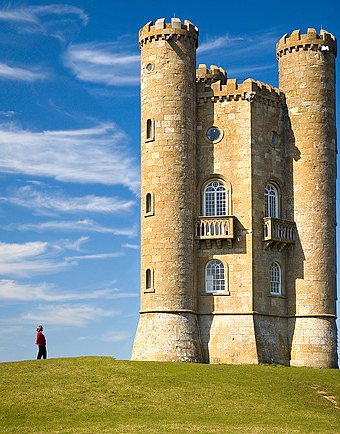

In [ ]:
show_pnm("/content/seam-carving/assets/output_host.pnm")

### Does it need to speed up?
Ứng dụng cần được tăng tốc vì thuật toán seam carving có độ phức tạp lớn khi thực hiện tuần tự(các bước hầu hết có độ phức tạp $O(n^2)$)
- Chuyển ảnh thành grayscale tốn $O(n^2)$, các pixel thực hiện độc lập với nhau
- Các bước convolution (blur ảnh, tìm cạnh, xây dựng energy map) tốn $O(n^2)$ để thực hiện convolution trên từng pixel ảnh 
- Bước quy hoạch động tìm seam có độ quan trọng nhỏ nhất hay xoá 1 seam đã được tìm thấy đều có độ phức tạp $O(n^2)$
- Xoá seams tốn $O(n^2)$, từng hàng thực hiện độc lập với nhau. Giống như một phép copy ma trận nhưng không tính những pixel thuộc về seams loại bỏ.

**$\Rightarrow$ Việc áp dụng tính toán song song trong bài toán này là rất phù hợp khi phần lớn các bước chính của thuật toán ta đều có thể song song hoá: grayscale, blur image, tính Energy Map, tìm seam, xóa seam**

## 3. Parallel implementation

Đây là phiên bản parallel đầu tiên được nhóm thực hiện qua các bước sau
- B1. Song song hoá việc chuyển ảnh thành grayscale
- B2. Song song hoá các hàm convolution(blur, edge detection, energy map)
- B3. Host thực hiện tính toán quy hoạch động 
- B4. Host thực hiện tìm seams có giá trị nhỏ nhất trong N seams
- B5. Host thực hiện truy vết ngược tuần tự để tìm ra seam này (hay các pixel cần xoá)
- B6. Thực hiện song song hoá xoá các pixel bằng việc flatten mảng input, copy các phần từ không có trên seam qua mảng output.

In [ ]:
!nvcc -arch=sm_{major}{minor} ./src/device_1/device_1.cu -o ./build/gpu_1

In [ ]:
!./build/gpu_1 ./assets/input.pnm /content/seam-carving/assets/output.pnm 300

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
****************************

Version GPU 1, seams: 300, time: 3283.574951 ms


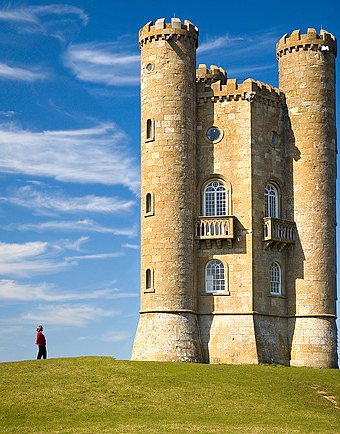

In [ ]:
show_pnm("/content/seam-carving/assets/output_dv1.pnm")

In [ ]:
!./build/gpu_1 ./assets/input.pnm /content/seam-carving/assets/output.pnm 10

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
****************************

Version GPU 1, seams: 10, time: 141.196960 ms


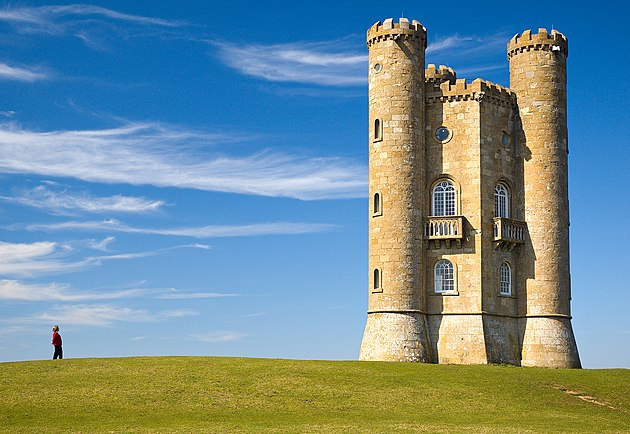

In [ ]:
show_pnm("/content/seam-carving/assets/output_dv1.pnm")

Tại thời điểm phiên bản này được chạy, tốc độ đo được khi đã xoá 300 seam ở phiên bản sequential là **31463ms** và phiên bản parallel là **3122ms**

$\Rightarrow$ Ta thấy rằng phiên bản parallel cho tốc độ hoàn thành chỉ bằng 1/10 so với phiên bản sequential.

## 4. Parallel implementation + optimization

**Version 2**
- Với các bước blur, tính convolution để tìm đặc trưng khi song song hoá, nhóm sử dụng SMEM giúp tăng tốc thuật toán.

In [ ]:
!nvcc -arch=sm_{major}{minor} ./src/device_2/device_2.cu -o ./build/gpu_2

In [ ]:
!./build/gpu_2 ./assets/input.pnm /content/seam-carving/assets/output.pnm 300

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
****************************

Version GPU 2, seams: 300, time: 3401.553223 ms


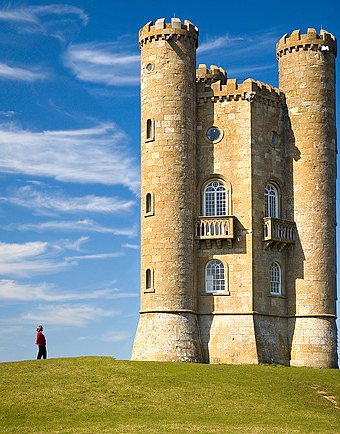

In [ ]:
show_pnm("/content/seam-carving/assets/output_dv2.pnm")

In [ ]:
!./build/gpu_2 ./assets/input.pnm /content/seam-carving/assets/output.pnm 10

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
****************************

Version GPU 2, seams: 10, time: 157.572479 ms


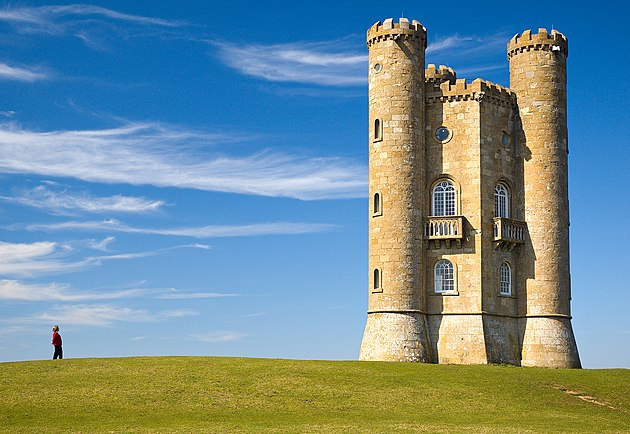

In [ ]:
show_pnm("/content/seam-carving/assets/output_dv2.pnm")

- Việc copy dữ liệu từ host sang device và từ device sang host tốn một lượng khá lớn, do đó khi chạy với số seam lớn khi dùng device thì thời gian chạy càng lúc càng thể hiện ít đi. 
- Cải thiện ở lần này chủ yếu với số lần thực hiện ít và lúc này sức mạnh của sự song song hóa sẽ được thể hiện. Khi số seam = 10 thì tốc độ cho thấy ở ***version 1*** là **136ms** còn ở ***version 2*** là **124ms**
- Còn khi số seam càng lớn, hiệu năng của việc tối ưu này ngang bằng với phiên bản cơ bản. Khi số seam = 300 thì tốc độ cho thấy ở ***version 1*** là **3098ms** còn ở ***version 2*** là **3055ms**

**Version 3**
- Với bước quy hoạch động tìm seam ít quan trọng nhất, thực hiện song song hoá trên từng hàng thay vì tuần tự với mỗi pixel

In [ ]:
!nvcc -arch=sm_{major}{minor} ./src/device_3/device_3.cu -o ./build/gpu_3

In [ ]:
!./build/gpu_3 ./assets/input.pnm /content/seam-carving/assets/output.pnm 300

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
****************************

Version GPU 3, seams: 300, time: 852.782410 ms


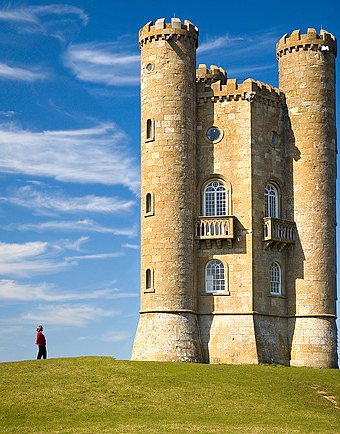

In [ ]:
show_pnm("/content/seam-carving/assets/output_dv3.pnm")

In [ ]:
!./build/gpu_3 ./assets/input.pnm /content/seam-carving/assets/output.pnm 10

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15843721216 bytes
****************************

Version GPU 3, seams: 10, time: 34.537697 ms


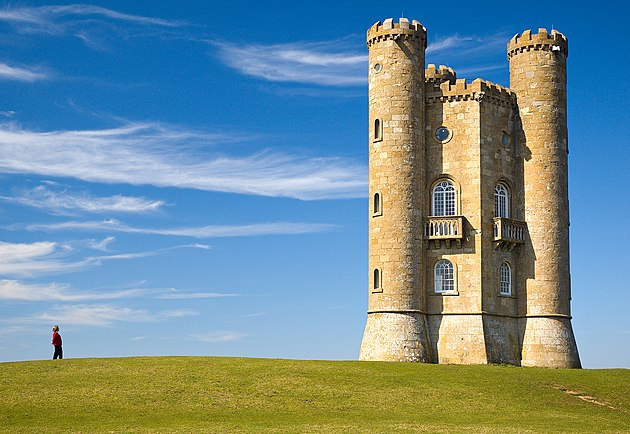

In [ ]:
show_pnm("/content/seam-carving/assets/output_dv3.pnm")

**Nhận xét**

- Khi thực hiện song song hoá các bước, thuật toán seam-carving đã cải thiện đáng kể về thời gian thực thi. 
- Về mặt tư tưởng khi thực hiện song song, nhóm không thay đổi tư tưởng gốc ban đầu và phiên bản song song hoá vẫn cải thiện được thời gian rõ rệt
- Khi số seam = 10 thì tốc độ cho thấy ở ***version 1*** là  **136ms** và ***version 2*** là **124ms** còn ở ***version 3*** là **30ms**
- Khi số seam = 300 thì tốc độ cho thấy ở ***version 1*** là  **3098ms** và ***version 2*** là **3055ms** còn ở ***version 3*** là **794ms**

## 5. Reflection
### What difficulties have you encountered?
**Trung**
- Gặp khó khăn khi chưa thành thạo với các syntax khi lập trình trên GPU.
- Việc tối ưu các version song song.
- Hạn chế về thời gian khiến việc thực hiện bị áp lực, chưa được chu đáo, cẩn thận.

**Trí**
- Thời gian hạn chế khiến việc lên kế hoạch và triển khai còn nhiều thiếu sót.
- Việc tìm kiếm tài liệu, giải thuật còn nhiều hạn chế.

### What have you learned?
**Trung**
- Teamwork, phối hợp với nhau để thực hiện đồ án.
- Cách làm việc chuyên nghiệp hơn, các thành viên sẽ có các buổi họp thảo luận và chia sẻ về phần của mình, có khó khăn gì sẽ được thành viên khác giúp đỡ, thời gian được phân chia rõ ràng cụ thể để thực hiện từng giai đoạn của đồ án.
- Tìm kiếm thông tin, tìm hiểu các phương pháp, các thuật toán giúp hoàn thiện đồ án. Việc tìm kiếm thông tin trên internet giúp em hiểu rõ hơn về thuật toán, cách áp dụng và thực hành từ đó rút ra kinh nghiệm cho bản thân để áp dụng vào đồ án.

**Trí**
- Kĩ năng mềm: teamwork
- Kĩ năng chuyên môn: tầm quan trọng của tối ưu phần mềm, cách tối ưu một ứng dụng theo hướng song song hóa, hiểu được quy trình hoạt động, các thành phần của một ứng dụng song song. Ngoài ra trong quá trình tìm kiếm thông tin, tài nguyên lúc học cũng là cơ hội để trau dồi một số kĩ năng khác: tìm kiếm, trích xuất thông tin, ...


### If you had more time, what would you do?
- Nếu có thêm thời gian, nhóm có thể sẽ tìm hiểu thêm cách tối ưu song song hoá để đạt được thời gian nhanh nhất và kết quả chính xác nhất.

## 6. References
https://developer.nvidia.com/blog/using-shared-memory-cuda-cc/

https://www.tutorialspoint.com/cuda/cuda_memories.htm

https://cs.brown.edu/courses/cs129/results/proj3/taox/

https://andrewdcampbell.github.io/seam-carving

https://avikdas.com/2019/05/14/real-world-dynamic-programming-seam-carving.html